Landau & Fries (2012) found that attention fluctuated rhythmically at approximately 4Hz with greater detection accuracy (attention) at peaks than troughs. Our goal is to replicate these findings using a sine wave. 

In [4]:
import numpy as np
import pandas as pd

n_trials = 50 # number of trials a given participant is doing 
baseline = 2.5 # baseline and amplitude are used to ensure our y-values fall between 0 and 5 seconds for reaction times. This is because in a regular sine function values are in the range of -1 to 1. So, amplitude stretches the range to -2 to 2 and baseline shifts it up to 0.5 to 4.5.
amplitude = -2.0 # amplitude is negative to invert the sine wave to ensure faster reaction times correspond to peaks and slower reaction times correspond to troughs.
noise = 0.3 # adding noise to ensure every participant has a differerent sine wave
n_participant = 10 # number of participants

time = np.linspace(0, 1, n_trials) # time will range from 0s post stimulus onset to 1 second post stimulus onset. Linspace is used to ensure there are 50 evenly spaced time values ranging from 0 to 1. This is necessary as the fast fourier transform requires evenly spaced data

all_data = [] # empty list that will be filled with the participants reaction times

for participant in range(1, n_participant + 1): # for loop that loops through the 10 participants 
    rt = baseline + amplitude*np.sin(2*np.pi*4*time) # reaction times are simulated following a sine wave. 2*np.pi is used to convert the x values into radians and this is multiplied by 4 to ensure we have a 4 cycles per second which produces a 4Hz sine wave.
    rt = rt + np.random.normal(0, noise, n_trials) # adding our noise to our reaction times
    
    rt = np.clip(rt, 0, 5) # np.clip ensures that the values remain between 0s and 5s

# creates a dataframe consisting of a participant column, trials column, time from stimulus onset column, and reaction time column
    data = pd.DataFrame({
    "participant": participant,
    "trials": np.arange(1, n_trials + 1),
    "time from stimulus onset" : time,
    "rt" : rt
    })
    
    all_data.append(data) # for each loop it appends the data to the empty list called all_data

df_combined = pd.concat(all_data) # pd.concat combines all of the data in the list into one data frame 

with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_combined) # instead of only printing some of the rows this prints all the rows and columns 

    participant  trials  time from stimulus onset        rt
0             1       1                  0.000000  2.604391
1             1       2                  0.020408  1.435921
2             1       3                  0.040816  0.841602
3             1       4                  0.061224  0.698554
4             1       5                  0.081633  0.244650
5             1       6                  0.102041  2.058445
6             1       7                  0.122449  2.366531
7             1       8                  0.142857  2.870254
8             1       9                  0.163265  3.905448
9             1      10                  0.183673  4.549621
10            1      11                  0.204082  4.373836
11            1      12                  0.224490  4.031638
12            1      13                  0.244898  2.034857
13            1      14                  0.265306  1.006662
14            1      15                  0.285714  0.796226
15            1      16                 

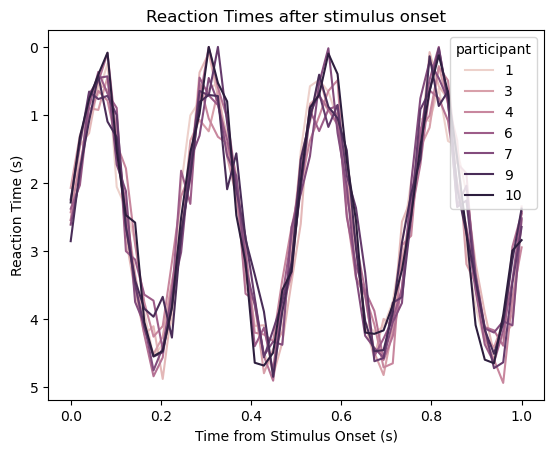

In [7]:
import seaborn as sns 
import matplotlib.pyplot as plt

sns.lineplot(data = df_combined, x = "time from stimulus onset", y = "rt", hue = "participant") 
# creates a lineplot using the data frame above. It takes in time from stimulus onset as the x value and rt as the y value. We also also produce several lines for each participant

plt.xlabel("Time from Stimulus Onset (s)") # plots the x-label
plt.ylabel("Reaction Time (s)") # plots the y-label
plt.title("Reaction Times after stimulus onset") # plots the title

plt.gca().invert_yaxis() # inverts the y-axis to visualize faster reaction times as peaks and slower reaction times as troughs 
# I asked chatgpt as I wasn't sure why it wasn't working. It required .gca. which stands for get current axes.

plt.show()

One of the analyses Landau and Fries (2012) did was fourier transform their data. This breaks the signal down into its component frequencies and then determines the amplitude of eac. We wanted to replicate the fast fourier transform analysis to show that we also find a larger amplitude at 4Hz suggesting that attention fluctuates at 4Hz.

Text(0.5, 1.0, 'FFT of Reaction Times')

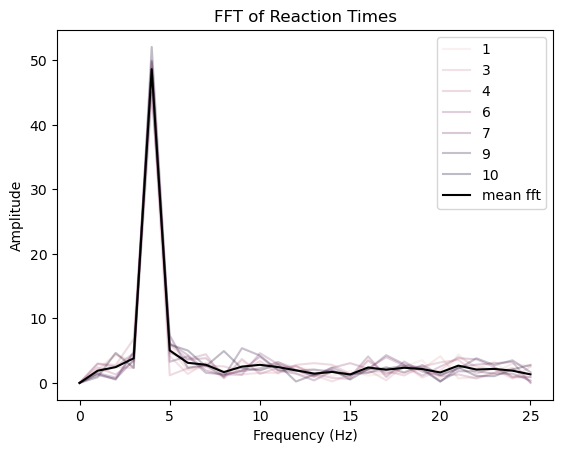

In [15]:
from scipy.fft import rfft, rfftfreq

sample_rate = 50 # sample rate is the number of data points that represent the sine wave in a given second
duration = 1 # length of the generated sample 
N = sample_rate * duration # number of data points within a given duration 

fft_all = [] # empty data frame that will house each participants fft

for participant in range(1, n_participant + 1): # a for loop that loops through each participant and calculates their fft
    by_participant = df_combined[df_combined['participant'] == participant] # a boolean mask used to index by participant.

    rt_demeaned = by_participant['rt'] - np.mean(by_participant['rt']) # we are demeaning the data to remove a DC offset which results in a big amplitude around 0hz. This masks other signals of interest like the 4Hz sine wave. Demeaning just involves subtracting the mean. 

# rfft and rfftfreq differs from fft and fftfreq as it only uses real numbers so it only plots the positive portion of the spectrum
    yf = rfft(rt_demeaned) # calculates the fast fourier transform
    xf = rfftfreq(N, 1/sample_rate ) # calculates the frequencies that make up each bin 

# creates a data frame consisting of the frequenecy of the fft, the amplitude of the fft, and the participant number
    fft_df = pd.DataFrame({
        'frequency': xf,
        'amplitude': np.abs(yf), # np.abs is used because its values are complex meaning it is comprised of a real and imaginary part.
        'participant': participant
    })

    fft_all.append(fft_df)  # for each loop it appends the data to the empty list called fft_all

fft_all = pd.concat(fft_all) # pd.concat combines all of the data in the list into one data frame 

mean_fft = fft_all.groupby('frequency', as_index = False)['amplitude'].mean() # this is calculating the mean fft across participants at each frequency. It does so by grouping participants at the same frequency and then averages the amplitude across participants.
# I needed chatgpt's help to get this to run. Particularly the part about as_index = False. Supposedly, for this to run frequency needs to be kept as a normal column instead of making it an index

# plots a lineplot of each participant's fft. Alpha changes the transparency of the line.
sns.lineplot(data = fft_all, x = 'frequency', y = 'amplitude', hue = 'participant', alpha = 0.3)

# plots a lineplot of the mean fft 
sns.lineplot(data = mean_fft, x = 'frequency', y = 'amplitude', color = 'black', label = 'mean fft')

plt.xlabel("Frequency (Hz)") # plots the x-label
plt.ylabel("Amplitude") # plots the y-label
plt.title("FFT of Reaction Times") # plots the title 

# resource used: https://realpython.com/python-scipy-fft/


In the second part of the experiment we have participants perform a recognition task in which they are shown old and new images. I hypothesize that participants that are "in the zone" will have better recognition memory than those "out of the zone". To illustrate this faster reaction times (which are associated with peaks in attention) will correspond to more correct answers (shown by a greater number of 1s). Whereas slower reaction times (which are associated with troughs in attention) will correspond to more incorrect answers (shown by a greater number of 0s). 

To showcase this relationship, what I did was I created a "for loop" and within that was an if statement followed by a nested if statement. This was done so that faster reaction times would have a greater chance of scoring 1 and slower reaction times would have a greater chance of scoring 0.

In [9]:
recognition = [] # empty list that will be filled with 1s and 0s for correct and incorrect responses, respectively.

for rt in df_combined['rt']: # loop through each reaction time in the data frame df_combined
    if rt < 2.5: # if reaction time is less than 2.5 then the object one has an 80% chance of appearing.
        one = np.random.random() < 0.80 
        if one == True: # if one does appear then append a 1 to the recognition list else if one is not present then append a 0
            recognition.append(1)
        elif one == False:
            recognition.append(0)  
    elif rt > 2.5: # else if reaction time is greater than 2.5 there is a 20% chance of zero appearing.
        zero = np.random.random() < 0.20 
        if zero == True: # if zero does appear than append a 1 to the recognition list else if zero is not present append a 0
            recognition.append(1)
        elif zero == False:
            recognition.append(0)

df_combined['recognition'] = recognition # this adds the recognition list to the existing data frame, df_combined
   

In [10]:
df_combined

,participant,trials,time from stimulus onset,rt,recognition
0,1,1,0.000000,2.604391,0
1,1,2,0.020408,1.435921,1
2,1,3,0.040816,0.841602,1
3,1,4,0.061224,0.698554,1
4,1,5,0.081633,0.244650,1
...,...,...,...,...,...
45,10,46,0.918367,4.599724,1
46,10,47,0.938776,4.652166,1
47,10,48,0.959184,3.944297,1
48,10,49,0.979592,2.994583,1


Next, we wanted to visualize the relationship between correct recognition responses and reaction times. To do this I created two histograms.

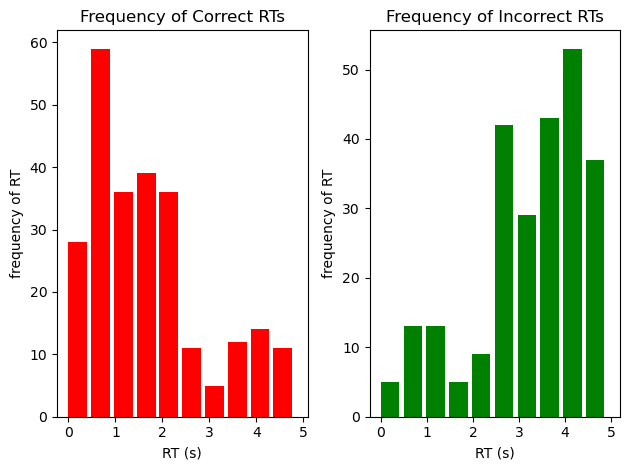

In [11]:
ones = df_combined[df_combined['recognition'] == 1]['rt'] # creates a boolean mask, filtering the dataframe, leaving only reaction times associated with correct recognition.
zeros = df_combined[df_combined['recognition'] == 0]['rt'] # creates a boolean mask, filtering the dataframe, leavimg only reaction times associated with incorrect recognition.

fig = plt.figure() # plots the blank figure 

axes1 = fig.add_subplot(1,2,1) # this adds a subplot consisting of 1 row and 2 columns. Axes1 will be the first subplot
axes2 = fig.add_subplot(1,2,2) # adds the second subplot

axes1.set_ylabel('frequency of RT') # sets the y-label for axes1 
axes1.set_xlabel ('RT (s)') # sets the x-label for axes1
axes1.set_title("Frequency of Correct RTs") # sets the title for axes1
axes1.hist(ones, color = 'red', width = 0.4) # using the filtered ones series, plot a histogram, that is red and with a bar width of 0.4

axes2.set_ylabel('frequency of RT') # sets the y-label for axes2
axes2.set_xlabel ('RT (s)') # sets the x-label for axes2
axes2.set_title("Frequency of Incorrect RTs") # sets the title for axes2
axes2.hist(zeros, color = 'green', width = 0.4) # using the filtered zeroes series, plot a histogram that is green and has a bar width of 0.4

fig.tight_layout() # adjusts the spacing of the plots 

I then wanted to look at the relationship between reaction times and recognition responses. To do so I looked at the pearson correlation and then plotted it. 

In [12]:
from scipy.stats import pearsonr

r, p =pearsonr(df_combined['rt'], df_combined['recognition']) # using pearsonr() function we determine the correlation of the variables reaction time and recognition in the df_combined dataframe. This produces the correlation coefficient and the p value

In [13]:
print(r) # prints the correlation coefficient 

-0.5485027981357111


In [17]:
print(p) # prints the p-value

1.285672089627549e-40


Text(0.5, 1.0, 'RT vs Recognition with a Regression Model')

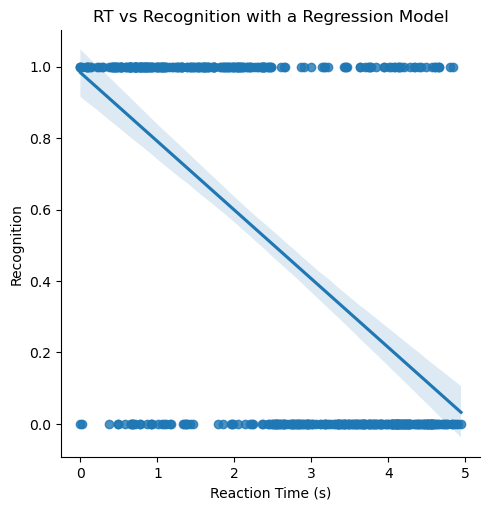

In [19]:

sns.lmplot(x='rt', y='recognition', data=df_combined) # lmplot is used to plot the relationship between reaction time and recognition using a regression model
plt.xlabel("Reaction Time (s)") # provides the x-label
plt.ylabel("Recognition") # provides the y-label
plt.title("RT vs Recognition with a Regression Model") # provides the title 

